In [107]:
from typing import List, Tuple, Dict, Optional, Set

from tqdm import tqdm
import itertools
from collections import Counter

import torch
from torch import nn
import allennlp
import numpy as np
import scipy
from scipy import sparse
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy

# local library imports
import dpd
from dpd.models.embedder import CachedTextFieldEmbedder
from dpd.constants import CADEC_ELMo, CADEC_BERT
from dpd.utils import H5SaveFile, get_all_embedders, TensorList, get_dataset_files
from dpd.dataset import BIODatasetReader, BIODataset, UnlabeledBIODataset, ActiveBIODataset

In [11]:
# Load our Contextual Word Representors
cwr_bert, cwr_elmo = get_all_embedders()
del cwr_bert

# Sampling Techniques

We use this notebook to explore different sampling strategies, namely we investigate
* `AgglomerativeClustering` to get a more diverse set, based on CWR vectors

## Agglomerative Clustering

We compute the `Agglomerative Cluster` to understand our data, and strategicially take samples. In particular:

1. Take the average `ELMo` vector to get a sentence embedding
2. Build index of sentence embeddings for each instance in the set
3. Build Agglomerative Cluster for dataset
4. Support API to sample N points that should be the N most distinct points

### Sentence Embedder

We use this to define a sentence embedding, for now, we use `ELMo` vectors for average embedding. But since we build on the CWR abstraction this could easily be replaced with `BERT`.

In [34]:
class SentenceEmbedder(nn.Module):
    def __init__(
        self,
        cwr: CachedTextFieldEmbedder,
        mode: str = 'avg',
    ):
        super(SentenceEmbedder, self).__init__()
        self.cwr = cwr
        self.mode = mode
    
    def _average_embedding(self, sentence_id: int, dataset_id: int) -> torch.Tensor:
        cwr_embedding: torch.Tensor = self.cwr.get_embedding(
            sentence_id=sentence_id,
            dataset_id=dataset_id,
        )
        
        return cwr_embedding.sum(dim=0) / len(cwr_embedding)
    
    def forward(
        self,
        sentence_ids: torch.Tensor, # (batch_size, )
        dataset_ids: torch.Tensor, # (batch_size, )
    ) -> torch.Tensor:
        embeddings: List[torch.Tensor] = [
            self._average_embedding(
                sentence_id=sentence_id.item(),
                dataset_id=dataset_id.item(),
            ).unsqueeze(0)
            for sentence_id, dataset_id in zip(sentence_ids, dataset_ids)
        ]
        return torch.cat(embeddings, dim=0)

In [35]:
sentence_embedder = SentenceEmbedder(cwr_elmo)
# sentence_embedder(torch.LongTensor([0, 1]), dataset_ids=torch.LongTensor([0, 0])).shape
# torch.Size([2, 1024])

torch.Size([2, 1024])

### Load the entire dataset

We use this dataset to load in our training and validation data for use throughout this notebook

In [46]:
train_file, valid_file, test_file = get_dataset_files(dataset='CADEC')
train_bio = BIODataset(
    dataset_id=0,
    file_name=train_file,
    binary_class='ADR',
)

train_bio.parse_file()

unlabeled_corpus = UnlabeledBIODataset(
    dataset_id=train_bio.dataset_id,
    bio_data=train_bio,
)

96867it [00:00, 345675.75it/s]


### Index the Dataset

Now that we have defined our sentence embedder, we can build an index of the entire dataset to apply our clustering algorithm on top of it

```
dataset_embed := TensorList()
for inst in dataset:
    sentence_embedding := embed(inst)
    dataset_embed.add(sentence_embedding)
return dataset_embed.numpy()
```

In [48]:
def build_index(dataset: UnlabeledBIODataset, sentence_embedder) -> TensorList:
    index = TensorList()
    for inst in tqdm(dataset):
        sentence_embedding: torch.Tensor = sentence_embedder(
            sentence_ids=torch.Tensor([inst['id']]),
            dataset_ids=torch.Tensor([dataset.dataset_id]),
        )
        index.append(sentence_embedding)
    return index

# TensorList(torch.Size([1000, 1024]))
index: TensorList = build_index(unlabeled_corpus, sentence_embedder)

100%|██████████| 1000/1000 [00:01<00:00, 559.46it/s]


## Clustering

Now that our preprocessing is done, we use this section to build our clusters, in particular `index` stores all our data. We use the implementation in `scikit learn` and `scipy` to cluster our data and build a sampler.

1. Cluster our data
2. Build sampling API from cluster

### Cluster

To cluster our data we rely on `sklearn.cluster.AgglomerativeClustering` and `scipy.cluster.hierarchy`.

In [163]:
def get_clusters(index: TensorList) -> AgglomerativeClustering:
    '''
    Runs agglomerative clustering on the `index` TensorList passed in
    '''
    index_np: np.ndarray = index.numpy()
    model = AgglomerativeClustering(linkage="average", affinity="cosine", n_clusters=500, compute_full_tree=True)
    model.fit(index_np)
    return model

def get_graph(index, model: AgglomerativeClustering) -> Dict[int, Dict[str, int]]:
    '''
    Given the results from an Agglomerative Cluster, returns the definition of the dendrogram
    over the clusters, to allow for the clusters to be built
    '''
    ii = itertools.count(len(index))
    graph = {next(ii): {'left': x[0], 'right':x[1]} for x in model.children_}
    return graph

model = get_clusters(index)

In [178]:
class HeirchicalClusterGraph(object):
    @classmethod
    def find_root(cls, adjacency_list: Dict[int, Dict[str, int]]) -> int:
        '''
        Given an adjacency list, return the node id for the root node
        '''
        all_left_children = [data['left'] for _, data in adjacency_list.items()]
        all_right_children = [data['right'] for _, data in adjacency_list.items()]
        all_children = set(all_left_children + all_right_children)
        all_nodes = adjacency_list.keys()
        potential_roots = list(filter(lambda x: x not in all_children, all_nodes))
        assert len(potential_roots) == 1
        return potential_roots[0]
    
    def __init__(
        self,
        index: TensorList,
    ):
        self.index: TensorList = index
        self.model: AgglomerativeClustering = get_clusters(index=index)
        self.adjacency_list: Dict[int, Dict[str, int]] = get_graph(index=index, model=self.model)
        self.root: int = HeirchicalClusterGraph.find_root(self.adjacency_list)
        
        self.layers: Dict[int, Set[int]] = {}
        self.height: Dict[int, Set[int]] = {}
        self.populate_layers(self.root, None, 0)
    
    def get_cluster_index(self, node_id: int) -> List[int]:
        if self.is_leaf(node_id):
            return [node_id]
        members = []

        children: Dict[str, int] = self.adjacency_list[node_id]
        members.extend(self.get_cluster_index(children['left']))
        members.extend(self.get_cluster_index(children['right']))
        return members
    
    def is_leaf(self, node_id: Optional[int]) -> bool:
        if node_id == None:
            return True
        children = node_id in self.adjacency_list and (
            ('left' in self.adjacency_list[node_id]) or
            ('right' in self.adjacency_list[node_id])
        )

        if not children:
            return True
        
        return False
    
    def populate_layers(self, node_id: int, parent_node: Optional[int], layer: int) -> int:
        if layer not in self.layers:
            self.layers[layer] = set()
        self.layers[layer].add(node_id)
        if node_id not in self.adjacency_list:
            self.adjacency_list[node_id] = {}
        self.adjacency_list[node_id]['parent'] = parent_node
        if not self.is_leaf(node_id):
            children = self.adjacency_list.get(node_id, None)
            lh = self.populate_layers(children['left'], node_id, layer + 1)
            rh = self.populate_layers(children['right'], node_id, layer + 1)
            h = max(lh, rh) + 1
        else:
            h = 0
        
        if h not in self.height:
            self.height[h] = set()
        self.height[h].add(node_id)
        
        return h
            
    
    def sample_points(sample_size: int) -> List[int]:
        '''
        Given a sample size, samples `sample_size` points
        from the HeirchicalCluster to ensure diversity
        
        returns indexes of points from original index
        '''
        pass
graph = HeirchicalClusterGraph(index)

In [179]:
print(list(map(lambda h: (h[0], len(h[1])), graph.layers.items())))
print(graph.adjacency_list[1998])
# '''
# (0, {1998}),
# (1, {384, 1997}),
# (2, {1892, 1996}),
# (3, {469, 1454, 1994, 1995}),
# (4, {386, 984, 1356, 1991, 1992, 1993}),
# (5, {336, 421, 445, 1250, 1980, 1987, 1989, 1990}),
# (6, {359, 402, 699, 748, 1155, 1972, 1977, 1981, 1983, 1988}),
# (7, {65, 66, 634, 780, 946, 982, 1127, 1954, 1962, 1967, 1974, 1986}),
# (8, {186, 193, 269, 391, 411, 425, 630, 1109, 1713, 1894, 1943, 1985}),
# (9, {106, 174, 623, 860, 905, 983, 1024, 1870, 1928, 1984}),
# (10, {97, 139, 191, 410, 502, 1016, 1976, 1982}),
# (11, {1009, 1015, 1965, 1968, 1971, 1979}),
# (12, {263, 455, 685, 719, 746, 809, 1008, 1012, 1925, 1940, 1975, 1978}),
# (13, {62, 158, 232, 662, 815, 839, 1007, 1011, 1961, 1964, 1970, 1973}),
# (14, {39, 246, 488, 615, 1006, 1010, 1939, 1942, 1945, 1951, 1966, 1969})
# '''

[(0, 1), (1, 2), (2, 2), (3, 4), (4, 6), (5, 8), (6, 10), (7, 12), (8, 12), (9, 10), (10, 8), (11, 6), (12, 12), (13, 12), (14, 12), (15, 16), (16, 18), (17, 12), (18, 8), (19, 12), (20, 12), (21, 10), (22, 10), (23, 10), (24, 10), (25, 14), (26, 20), (27, 12), (28, 18), (29, 22), (30, 20), (31, 24), (32, 24), (33, 16), (34, 14), (35, 6), (36, 4), (37, 4), (38, 4), (39, 8), (40, 4), (41, 2), (42, 4), (43, 6), (44, 6), (45, 8), (46, 10), (47, 10), (48, 12), (49, 4), (50, 4), (51, 6), (52, 6), (53, 6), (54, 6), (55, 10), (56, 6), (57, 6), (58, 8), (59, 6), (60, 12), (61, 8), (62, 10), (63, 12), (64, 16), (65, 16), (66, 16), (67, 14), (68, 8), (69, 10), (70, 6), (71, 4), (72, 6), (73, 8), (74, 12), (75, 8), (76, 14), (77, 16), (78, 24), (79, 26), (80, 26), (81, 22), (82, 14), (83, 16), (84, 14), (85, 14), (86, 14), (87, 14), (88, 14), (89, 14), (90, 20), (91, 8), (92, 10), (93, 10), (94, 12), (95, 16), (96, 8), (97, 12), (98, 8), (99, 10), (100, 12), (101, 16), (102, 16), (103, 14), (104,

In [167]:
Counter(model.labels_).most_common(10)

[(4, 256),
 (14, 26),
 (118, 20),
 (46, 17),
 (1, 14),
 (9, 13),
 (30, 9),
 (28, 8),
 (5, 8),
 (230, 7)]

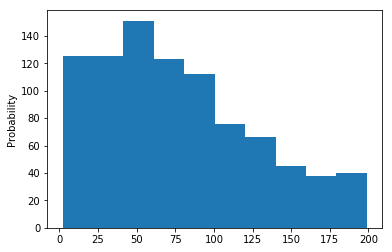